In [1]:
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
import numpy as np
import pandas as pd
import  gym
import seaborn as sns
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA
import os

In [2]:
df = pd.read_csv('data/N2.csv')

In [3]:
data = df.drop(columns=["Date"])
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = df[~((df[1:] < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
# Remove outliers
df.drop(df[((df[1:] < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)].index ,inplace=True ,axis=0)
print("Done")

Done


C:\Users\moham\AppData\Local\Temp\ipykernel_28924\509617364.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\moham\AppData\Local\Temp\ipykernel_28924\509617364.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\moham\AppData\Local\Temp\ipykernel_28924\509617364.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = df[~((df[1:] < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
C:\Users

In [4]:
# df.drop(['Name'],axis=1,inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df[['MACD', 'MACD_signal']] = TA.MACD(df)
df.fillna(0, inplace=True)
df.set_index('Date',inplace=True)

In [6]:
x_train,x_test = train_test_split(df , test_size=0.1)
del  df

In [7]:
models_dir = "models/A2C"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)


In [8]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV','MACD', 'MACD_signal']].to_numpy()[start:end]
    return prices, signal_features

In [9]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env_train = MyCustomEnv(df=x_train, window_size=12, frame_bound=(12,x_train.shape[0]))

In [10]:
env_maker = lambda: env_train
env = DummyVecEnv([env_maker])

In [11]:
timesteps=10_000
model = A2C('MlpPolicy' , env = env_train , verbose=1 ,tensorboard_log=logdir)
for i in range(1,30):
    model.learn(total_timesteps=timesteps ,reset_num_timesteps=False, tb_log_name="A2C" )
    model.save(f"{models_dir}/A2C{i*timesteps}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_0
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 190      |
|    ep_rew_mean        | 740      |
| time/                 |          |
|    fps                | 156      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0.0022   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -513     |
|    value_loss         | 6.36e+05 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 190       |
|    ep_rew_mean        | 1.12e+03  |
| time/                 |           |
|    fps                | 240       |
|    iterations         | 2

info {'total_reward': 935.0000000000018, 'total_profit': 1.0222185713563725, 'position': 1}


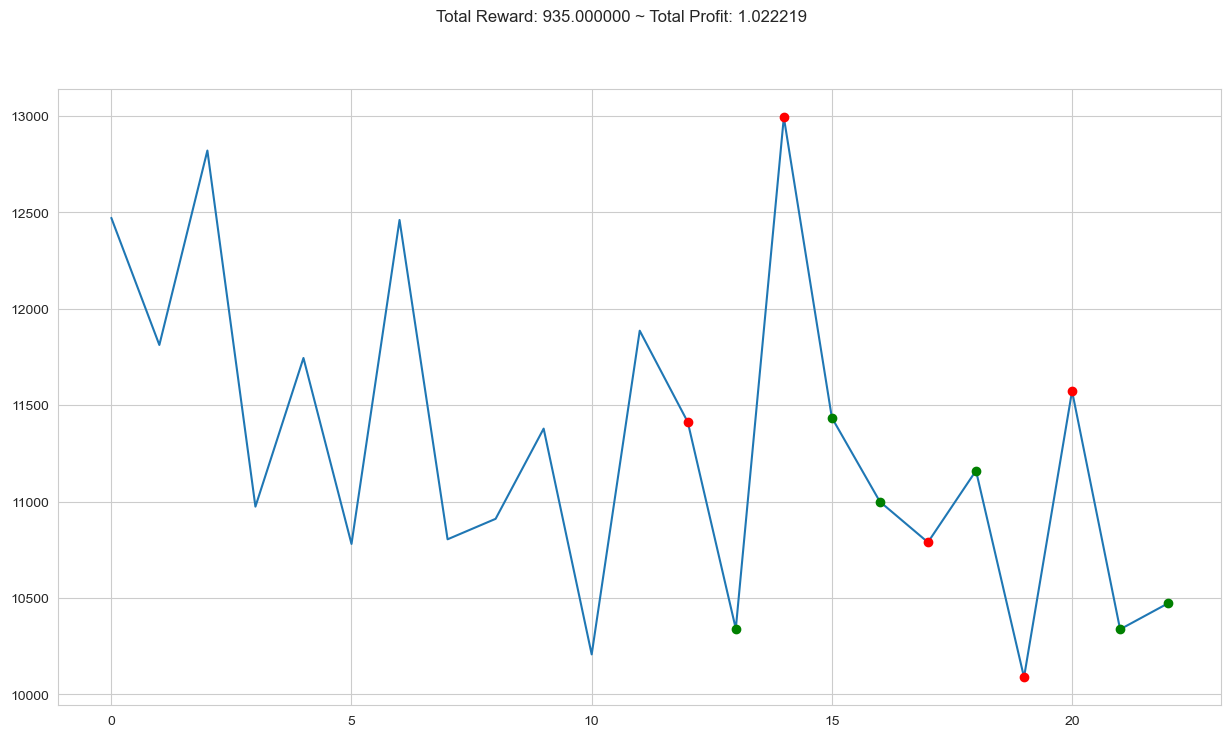

In [12]:
env = MyCustomEnv(df=x_test, window_size=12 ,frame_bound=(12,100))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15, 8))
plt.cla()
env.render_all()
plt.show()